In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=6, linewidth=110)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import copy

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import surrogate
import diagnostics
import plotparams

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(plotparams)

import constants
imp.reload(constants)
from constants import *

# Error estimate functions

In [4]:
def rms_phase_error(i, h_testset, sur, mfmax=0.1):
    """Root-mean-squared phase error at the phase empirical nodes.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    # Phase at the empirical nodes for true and surrogate waveforms
    phase_true = htrue.interpolate('phase')(sur.mf_phase)
    phase_sur = hsur.interpolate('phase')(sur.mf_phase)

    nphase = len(sur.mf_phase)
    phase_diff = phase_sur-phase_true
    
    # Cut samples above mfmax
    phase_diff = phase_diff[sur.mf_phase<=mfmax]
    
    rms_error = np.sqrt(np.sum(phase_diff**2)/nphase)
    return params, rms_error

In [5]:
def max_fractional_amp_error(amp_sur, amp_true):
    """Calculate A_sur / A_true - 1.
    """
    error = amp_sur/amp_true - 1.0
    return np.max(np.abs(error))

def max_phase_error(phase_sur, phase_true):
    """Calculate Phi_sur - Phi_true.
    """
    error = phase_sur - phase_true
    return np.max(np.abs(error))

def max_amp_phase_error(i, h_testset, sur, mfmax=0.1):
    """Fractional amplitude error and phase error maximized over.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    amp_true = htrue.amp
    phase_true = htrue.phase
    
    amp_sur = hsur.amp
    phase_sur = hsur.phase
    
    # Cut samples above mfmax
    amp_sur = amp_sur[hsur.x<=mfmax]
    amp_true = amp_true[htrue.x<=mfmax]
    phase_sur = phase_sur[hsur.x<=mfmax]
    phase_true = phase_true[htrue.x<=mfmax]
    
    amp_error = max_fractional_amp_error(amp_sur, amp_true)
    phase_error = max_phase_error(phase_sur, phase_true)
    
    return params, amp_error, phase_error

In [6]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross


def mismatch(h1, h2, f_min, f_max):
    """Mismatch between h1, h2.
    
    Parameters
    ----------
    h1, h2 : pycbc FrequencySeries
    f_min : float
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, 
                                  low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)[0]


def surrogate_mismatch(i, h_testset, sur, mf_min, mf_max, delta_f=1.0, mtot=2.0, distance=100., inclination=0):
    """Mismatch between surrogate and testset.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mtot/(1+q)
    mass2 = q*mass1
    f_min = mf_to_f(mf_min, mtot)
    f_max = mf_to_f(mf_max, mtot)
    #print f_min, f_max, mass1, mass2
    f_ref = f_min
    phi_ref = 0.
    
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        htrue, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    # Generate surrogate waveform
    hp_sur_phys, hc_sur_phys = sur.physical_waveform_pycbc(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
        distance=distance, inclination=inclination, phi_ref=phi_ref)
    
    return params, mismatch(hp_true_phys, hp_sur_phys, f_min, f_max)


def taylorf2_mismatch(i, h_testset, sur, mf_min, mf_max, delta_f=1.0, mtot=2.0, distance=100., inclination=0):
    """Mismatch between surrogate and testset.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hf2 = sur.geometric_reference_waveform(params)
    # Resample and zero starting phase
    hf2.resample(htrue.x)
    hf2.phase -= hf2.phase[0]
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mtot/(1+q)
    mass2 = q*mass1
    f_min = mf_to_f(mf_min, mtot)
    f_max = mf_to_f(mf_max, mtot)
    #print f_min, f_max, mass1, mass2
    f_ref = f_min
    phi_ref = 0.
    
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        htrue, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
     # Generate TaylorF2 waveform in physical units
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        hf2, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_f2_phys, hc_f2_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    return params, mismatch(hp_true_phys, hp_f2_phys, f_min, f_max)

# Load GPSurrogate and test set

In [94]:
###### Matern 5/2 ########

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_corners_lhd_xi.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_corners_lhd_xi.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_corners_lhd_xi.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uniform_xi.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uniform_xi.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uniform_xi.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uncsamp_xi.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uncsamp_xi.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uncsamp_xi.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uncsamp_uniform_xi.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uncsamp_uniform_xi.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uncsamp_uniform_xi.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

###### Squared exponential ########

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_corners_lhd_xi_sqexp.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_corners_lhd_xi_sqexp.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_corners_lhd_xi_sqexp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uniform_xi_sqexp.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uniform_xi_sqexp.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uniform_xi_sqexp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uncsamp_xi_sqexp.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uncsamp_xi_sqexp.hdf5'
# nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uncsamp_xi_sqexp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

gp_amp_filename = '../../data/TEOBv4QM_production/gp_spline_amp_lhd_uncsamp_uniform_xi_sqexp.hdf5'
gp_phase_filename = '../../data/TEOBv4QM_production/gp_spline_phase_lhd_uncsamp_uniform_xi_sqexp.hdf5'
nodes_filename = '../../data/TEOBv4QM_production/nodes_lhd_uncsamp_uniform_xi_sqexp.hdf5'
sur = surrogate.GPSplineSurrogate.load(
    nodes_filename, gp_amp_filename, gp_phase_filename, 
    order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)


In [95]:
# The final reference waveforms (test set 2). Test set 1 is more like a validation set.

# testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_production/h_test1.hdf5')
# dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_production/dh_test1.hdf5')

testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_production/h_test2.hdf5')
dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_production/dh_test2.hdf5')

# Calculate errors

In [96]:
i = 912
mtot = 2.8
mf_min = sur.mf_a
mf_max = sur.mf_b
print mf_min, mf_max
f_min = mf_to_f(mf_min, mtot)
f_max = mf_to_f(mf_max, mtot)
print f_min, f_max

params, mm = surrogate_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
print params, mm

0.0002099999999999999 0.07000000000000002
15.226908263775181 5075.636087925064
[ 5.401831e-01 -2.886606e-01 -4.417781e-01  1.579330e+03  2.588035e+02] 0.00033573032553113613


In [97]:
mtot = 2.8
mf_min = sur.mf_a
mf_max = sur.mf_b
print mf_min, mf_max

params_rand = []
rms_err = []
max_amp_err = []
max_phase_err = []
mismatch_sur = []
mismatch_f2 = []

for i in range(len(testset_rand)):
#for i in range(100):
    print i,
    
    # RMS phase error
    params, pe = rms_phase_error(i, testset_rand, sur, mfmax=0.03)
    params_rand.append(params)
    rms_err.append(pe)
    
    # Max amp and phase error
    params, ae, pe = max_amp_phase_error(i, testset_rand, sur, mfmax=0.03)
    max_amp_err.append(ae)
    max_phase_err.append(pe)
    
    # Mismatch with surrogate
    params, mm = surrogate_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
    mismatch_sur.append(mm)
    
    # Mismatch with TaylorF2
    params, mm = taylorf2_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
    mismatch_f2.append(mm)
    
# Convert lists to numpy arrays
params_rand = np.array(params_rand)
rms_err = np.array(rms_err)
max_amp_err = np.array(max_amp_err)
max_phase_err = np.array(max_phase_err)
mismatch_sur = np.array(mismatch_sur)
mismatch_f2 = np.array(mismatch_f2)

0.0002099999999999999 0.07000000000000002
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 

In [98]:
params_errors = np.concatenate((params_rand.T, 
                                np.array([rms_err]), 
                                np.array([max_amp_err]), 
                                np.array([max_phase_err]), 
                                np.array([mismatch_sur]), 
                                np.array([mismatch_f2])
                               )).T

# Maximum value of the various error columns
print np.amax(params_errors, axis=0)[5:]


# Save errors data

####### Matern 5/2 kernel #######

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_xi.txt', params_errors, 
#            header='Errors between the 160LHD+corners training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uniform_xi.txt', params_errors, 
#            header='Errors between the 560LHD+corners+rand_in_xi training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uncsamp_xi.txt', params_errors, 
#            header='Errors between the 560LHD+corners+uncertainty sampling in xi training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uncsamp_uniform_xi.txt', params_errors, 
#            header='Errors between the 960LHD+corners+uncertainty_sampling+uniform_in_xi training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

######## Squared exponential kernel ########

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_xi_sqexp.txt', params_errors, 
#            header='Errors between the 160LHD+corners training set and test_set_2 with squared exponential kernel\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uniform_xi_sqexp.txt', params_errors, 
#            header='Errors between the 560LHD+corners+rand_in_xi training set and test_set_2 with squared exponential kernel\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uncsamp_xi_sqexp.txt', params_errors, 
#            header='Errors between the 560LHD+corners+uncertainty sampling in xi training set and test_set_2 with squared exponential kernel\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_production/errors_test_set2_lhd_uncsamp_uniform_xi_sqexp.txt', params_errors, 
           header='Errors between the 960LHD+corners+uncertainty_sampling+uniform_in_xi training set and test_set_2 with squared exponential kernel\n'
           +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
           +'mismatch_sur, mismatch_f2')

[7.090116e-01 3.859327e+00 2.764590e+00 5.581425e-04 1.513176e-01]


In [99]:
imax = np.argmax([params_errors[:, 8]])
print imax
params_errors[imax]

101


array([ 3.734683e-01, -1.504915e-01,  3.482337e-01,  4.135736e+00,  2.306321e+03,  2.055066e-01,
        5.789209e-02,  6.289894e-01,  5.581425e-04,  6.987047e-03])

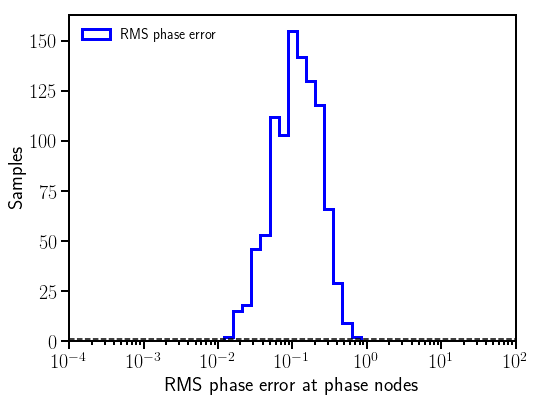

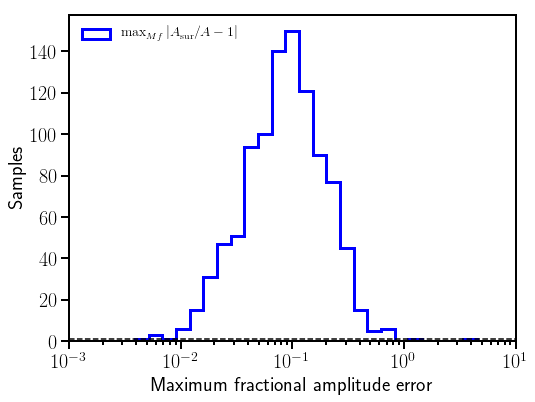

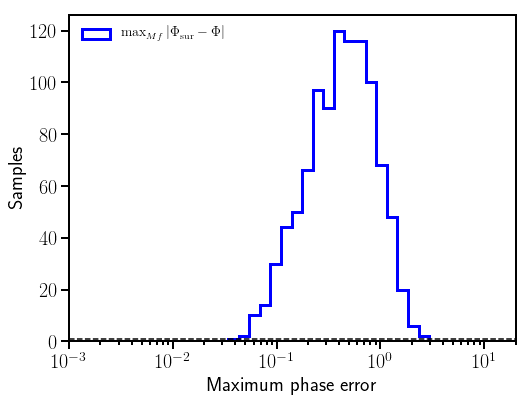

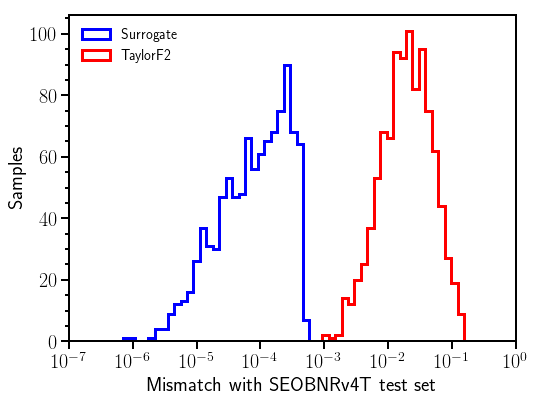

In [100]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 5], bins=np.logspace(-4, 2, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'RMS phase error')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-4, 100.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('RMS phase error at phase nodes')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)




fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(params_errors[:, 6], bins=np.logspace(-4, 2, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 10.0])
#ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)



fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 7], bins=np.logspace(-3, 2, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 20.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)



fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(params_errors[:, 8], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'Surrogate')
ax.hist(params_errors[:, 9], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'TaylorF2')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1.0e-7, 1.0])
ax.set_xticks([1.0e-7, 1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0e0])
ax.minorticks_on()
ax.set_xlabel(r'Mismatch with SEOBNRv4T test set')
ax.set_ylabel('Samples')
ax.legend(loc='upper left', frameon=False)

In [101]:
# j=8

# lam1 = params_errors[:, 3]
# lam2 = params_errors[:, 4]
# #print lam1
# error = params_errors[:, j]
# error = error[(lam1>1000) & (lam2>1000)]


# fig, ax = plt.subplots(figsize=(8, 6))
# ax.hist(error, bins=np.logspace(-10, 0, 100), histtype='step', 
#           ls='-', lw=3, color='blue', alpha=1.0, label=r'Surrogate')
# ax.hist(params_errors[:, 9], bins=np.logspace(-10, 0, 100), histtype='step', 
#           ls='-', lw=3, color='red', alpha=1.0, label=r'TaylorF2')

# #ax.axhline(1.0, c='k', ls='--')
# ax.set_xscale('log')
# #ax.set_yscale('log')
# ax.set_xlim([1.0e-7, 1.])
# #ax.set_ylim([0.9, 1000])
# ax.set_xlabel('Mismatch with test set')
# ax.set_ylabel('Samples')
# ax.legend(loc='upper left', frameon=False)
# ax.minorticks_on()

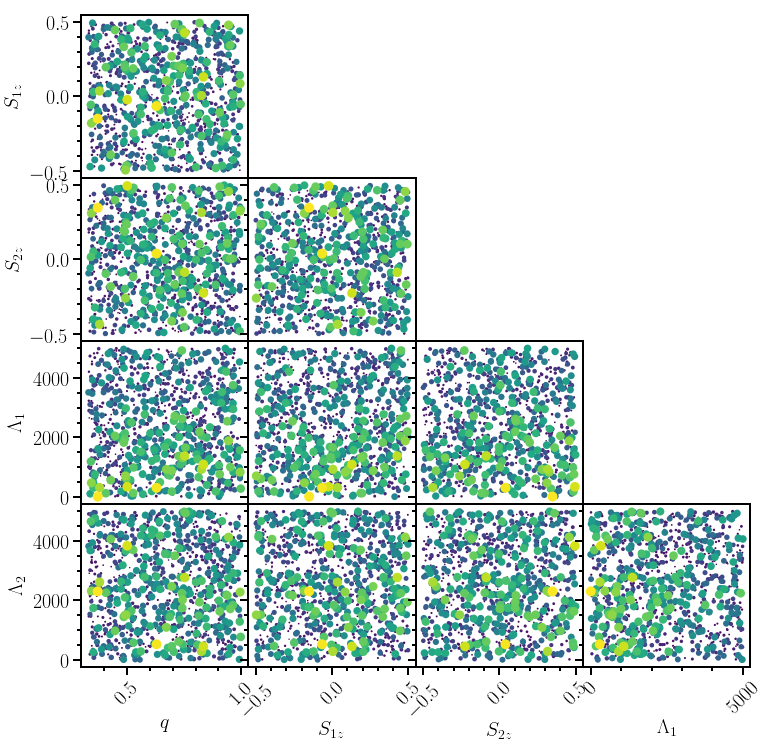

In [102]:
j=8

error = params_errors[:, j]
params = params_errors[:, :5]

labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

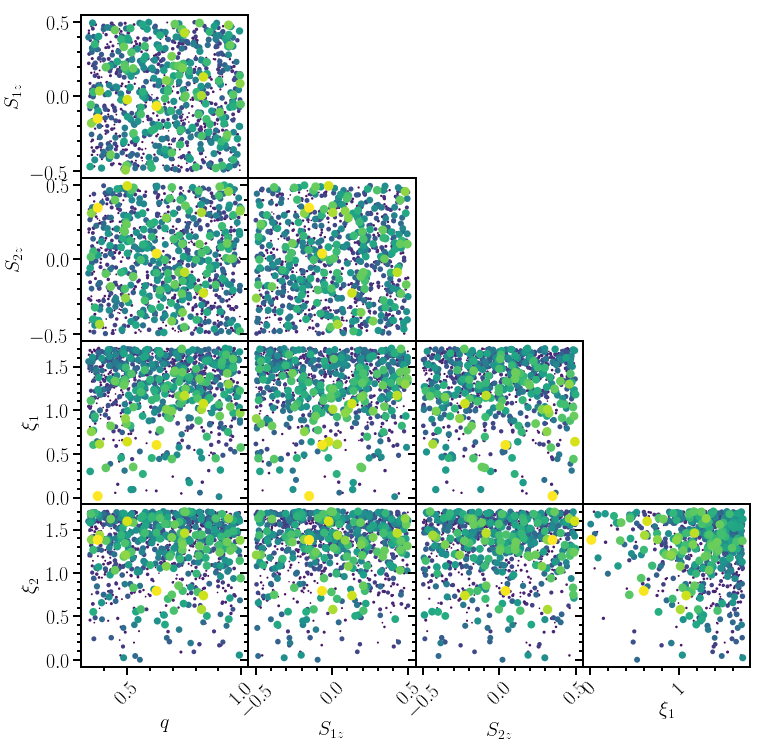

In [103]:
j=8

error = params_errors[:, j]
params = copy.copy(params_errors[:, :5])

# mask = error < 3.0e-3
# error = error[mask]
# params = params_errors[mask, :5]

def xi_of_lam(lam, a=100):
    return np.log10(lam/a + 1)

params[:, 3] = xi_of_lam(params[:, 3])
params[:, 4] = xi_of_lam(params[:, 4])
#labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\xi_1$', r'$\xi_2$']
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Largest mismatch waveform

101 [ 3.734683e-01 -1.504915e-01  3.482337e-01  4.135736e+00  2.306321e+03] 0.0005581425178157184


Text(0.5,0,'$Mf$')

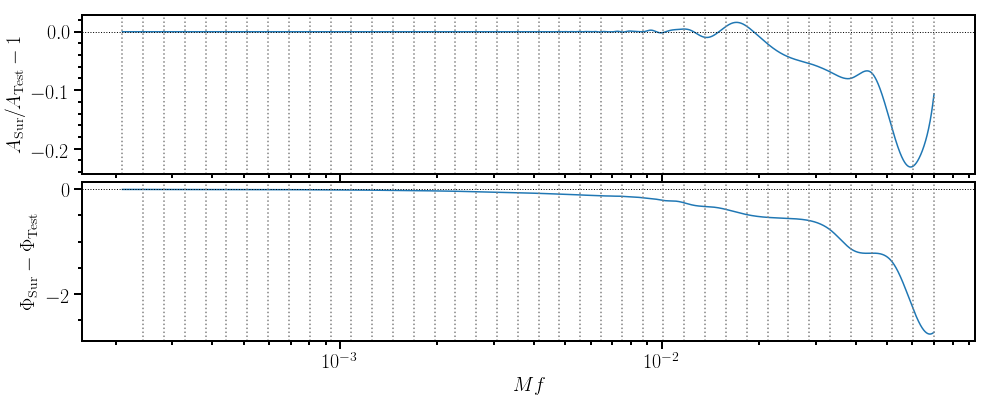

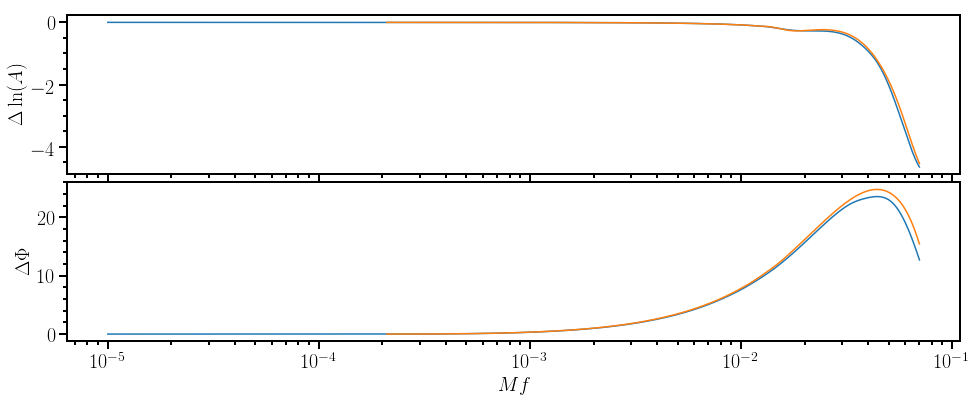

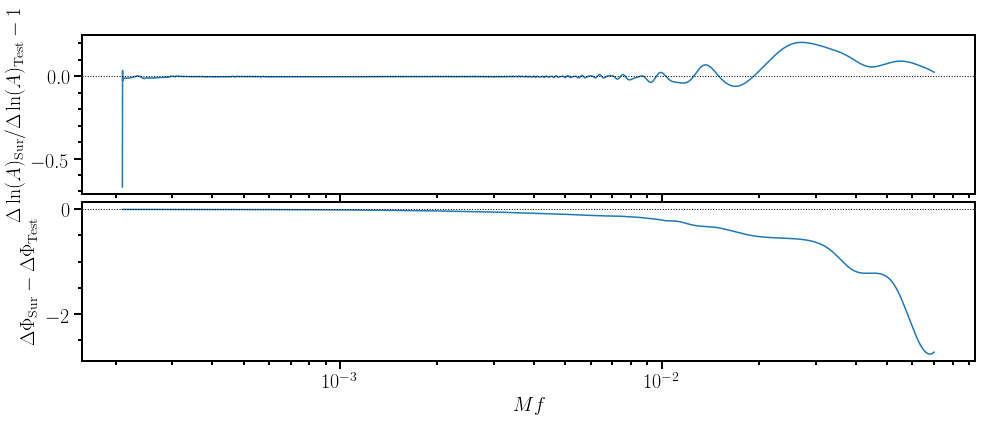

In [104]:
j_err = 8
i_max = np.argmax(params_errors[:, j_err])
#i_max = 0
p = params_errors[i_max, :5]
print i_max, p, params_errors[i_max, j_err]

htest = testset_rand[i_max]
hsur = sur.geometric_waveform(p)
# Resample and zero starting phase
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

dhtest = dtestset_rand[i_max]
dhsur = sur.amp_phase_difference(p)


fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.1, 0.1)
#ax2.set_ylim(-2, 2)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$A_{\rm Sur}/A_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm Sur}-\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')


fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dhsur, dhtest)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

# Create 3rd training set from largest phase error waveforms

In [26]:
# params = params_errors[:, :5]
# errors = params_errors[:, 5]
# i_above_thresh = np.where(errors>=0.1)[0]
# print i_above_thresh
# new_params = params[i_above_thresh]
# new_errors = errors[i_above_thresh]

# print len(new_errors)
# new_errors

In [30]:
# new_h_list = [testset_rand[i] for i in i_above_thresh]
# new_dh_list = [dtestset_rand[i] for i in i_above_thresh]

# h_filename = '../../data/teobtest40hz/h_train_rand.hdf5'
# dh_filename = '../../data/teobtest40hz/dh_train_rand.hdf5'
# ws.waveform_set_from_list(h_filename, new_h_list, new_params)
# ws.waveform_set_from_list(dh_filename, new_dh_list, new_params)

In [31]:
# filename1 = '../../data/teobtest40hz/h_train_lhd_uncsamp.hdf5'
# filename2 = '../../data/teobtest40hz/h_train_rand.hdf5'
# filename_join = '../../data/teobtest40hz/h_train_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)

# filename1 = '../../data/teobtest40hz/dh_train_lhd_uncsamp.hdf5'
# filename2 = '../../data/teobtest40hz/dh_train_rand.hdf5'
# filename_join = '../../data/teobtest40hz/dh_train_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)